# Stock Price Prediction

In this codebook, I modified the code from the a pennylane article mentioned below and used it for stock price prediction. I converted all the classical data which includes both the features and the target variable data, into quantum data. Then, a Quantum Neural Network based regression model is applied to train a model to predict the stock prices. Lastly, a formula for converting the predicted quantum data into classical data (taken from ChatGPT) is used to convert the  quantum data back to classical data. There are 3 attempts, the default, attempt 1 and attempt 2 which showcase the conversion of classical data into quantum data using 3 different ansatz respectively.

Article Link: https://pennylane.ai/qml/demos/tutorial_qnn_multivariate_regression

In [ ]:
# !pip install pennylane 
# !pip install optax
# !pip install numpy
# !pip install matplotlib
# !pip install openchart
# !pip install jax 
# !pip install jaxlib
# !pip install scikit-learn

## Functions

In [17]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import jax
from jax import numpy as jnp
import optax
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
from openchart import NSEData
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")

pnp.random.seed(42)

dev1 = qml.device('default.qubit', wires=2)

In [18]:
# Creating a quantum reservior
# Adding non-linearity by converting the data into higher dimensional data
# Using angle encoding to get the data as quantum state probability amplitudes

reservoir_depth=5
qubits=4

dev2=qml.device('lightning.qubit',wires=qubits)

@qml.qnode(device=dev2)
def quantum_reservoir(data_point,theta_1,theta_2,wires=qubits,reservoir_depth=reservoir_depth,seed=42):
    pnp.random.seed(42)

    for i, value in enumerate(data_point):
        qml.Hadamard(wires=i)
        qml.RX(2*pnp.pi*value,wires=i)
        qml.RY(pnp.pi*value,wires=i)
        qml.RZ(3*pnp.pi*value,wires=i)

    for _ in range(reservoir_depth):

        for i in range(wires):
            qml.RY(pnp.random.uniform(0,pnp.pi),wires=i)

        for i in range(wires-1):
            qml.CNOT(wires=[i,i+1])

        for i in range(wires-2):
            qml.CRX(theta_1,wires=[i,i+1])
            qml.CRZ(theta_2,wires=[i+1,i+2])

    return qml.probs(wires=range(wires))

def extract_features(data,qubits,reservoir_depth):
    features=[]
    theta_1=pnp.pi/6
    theta_2=pnp.pi/4

    for data_point in data:
        exp_val=quantum_reservoir(data_point=data_point,theta_1=theta_1,theta_2=theta_2,wires=qubits,reservoir_depth=reservoir_depth)
        features.append(exp_val)

    return features


In [19]:
# Quantum Neural Network

def S(x):
    qml.AngleEmbedding( x, wires=[0,1],rotation='Z')

def W(params):
    qml.StronglyEntanglingLayers(params, wires=[0,1])

@qml.qnode(dev1,interface="jax")
def quantum_neural_network(params, x):
    layers=len(params[:,0,0])-1
    n_wires=len(params[0,:,0])
    n_params_rot=len(params[0,0,:])
    for i in range(layers):
      W(params[i,:,:].reshape(1,n_wires,n_params_rot))
      S(x)
    W(params[-1,:,:].reshape(1,n_wires,n_params_rot))

    return qml.expval(qml.PauliZ(wires=0)@qml.PauliZ(wires=1))

In [20]:
# Optimization for the quantum neural network algorithm

@jax.jit
def mse(params,x,targets):
    # We compute the mean square error between the target function and the quantum circuit to quantify the quality of our estimator
    return (quantum_neural_network(params,x)-jnp.array(targets))**2
@jax.jit
def loss_fn(params, x,targets):
    # We define the loss function to feed our optimizer
    mse_pred = jax.vmap(mse,in_axes=(None, 0,0))(params,x,targets)
    loss = jnp.mean(mse_pred)
    return loss

opt = optax.adam(learning_rate=0.05)
max_steps=300

@jax.jit
def update_step_jit(i, args):
    # We loop over this function to optimize the trainable parameters
    params, opt_state, data, targets, print_training = args
    loss_val, grads = jax.value_and_grad(loss_fn)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    def print_fn():
        jax.debug.print("Step: {i}  Loss: {loss_val}", i=i, loss_val=loss_val)
    # if print_training=True, print the loss every 50 steps
    jax.lax.cond((jnp.mod(i, 50) == 0 ) & print_training, print_fn, lambda: None)
    return (params, opt_state, data, targets, print_training)

@jax.jit
def optimization_jit(params, data, targets, print_training=False):
    opt_state = opt.init(params)
    args = (params, opt_state, jnp.asarray(data), targets, print_training)
    # We loop over update_step_jit max_steps iterations to optimize the parameters
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, max_steps+1, update_step_jit, args)
    return params

def evaluate(params, data):
    y_pred = jax.vmap(quantum_neural_network, in_axes=(None, 0))(params, data)
    return y_pred

# **Openchart Stock Data Prediction**

In [21]:
# Downloading the NSE and NFO meta data
nse=NSEData()
nse.download()

NSE data shape: (3161, 4)
NFO data shape: (87662, 4)
NSE and NFO data downloaded successfully.


In [22]:
# Downloading the historical stock data for Reliance for 1 minute time intervals for a month
end_date=datetime.datetime.today()
start_date=end_date-datetime.timedelta(days=30)

data=nse.historical(
    symbol='RELIANCE',
    start=start_date,
    end=end_date,
    interval='1m',
    exchange='NSE'
)

In [23]:
# Data preprocessing

data.columns=data.columns.str.lower()

data['target']=data['close'].shift(-1)
data.dropna(inplace=True)

x_train=data[['open','close']] #.to_numpy()
y_train=data['target'].to_numpy()

scaler=StandardScaler() # MinMaxScaler()
x_train=scaler.fit_transform(x_train)

# x_train=x_train[0:100]
# y_train=y_train[0:100]

@qml.qnode(dev1)
def single_measurement(x):
    qml.Hadamard(wires=0)
    qml.RZ(x, wires=0)
    return qml.expval(qml.PauliZ(0))

def quantum_transform(data):
    return [single_measurement(d) for d in data]

y=y_train.copy()
y_train=quantum_transform(y_train)
y_train=pnp.array(y_train)

print('Reliance Data:')
print(data.head())
print('\n')
print('x_train: ',x_train[0:5])
print('\n')
print('y_train: ',y_train[0:5])
print('\n')
print('x_train shape: ',x_train.shape)
print('\n')
print('y_train shape: ',y_train.shape)

Reliance Data:
                       open    high     low   close  volume  target
Timestamp                                                          
2025-10-15 12:19:59  1376.6  1377.4  1376.6  1377.1   17397  1377.2
2025-10-15 12:20:59  1377.1  1377.4  1377.1  1377.2   16999  1377.3
2025-10-15 12:21:59  1377.2  1377.3  1376.3  1377.3   26267  1377.6
2025-10-15 12:22:59  1377.5  1377.6  1377.0  1377.6   40577  1377.5
2025-10-15 12:23:59  1377.6  1377.6  1377.5  1377.5    6539  1377.9


x_train:  [[-2.75584204 -2.74249027]
 [-2.74191512 -2.73970453]
 [-2.73912973 -2.7369188 ]
 [-2.73077358 -2.72856158]
 [-2.72798819 -2.73134732]]


y_train:  [0. 0. 0. 0. 0.]


x_train shape:  (7190, 2)


y_train shape:  (7190,)


In [24]:
# Running the quantum neural network

wires=2
layers=4
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=layers+1,n_wires=wires)
params=pnp.random.default_rng().random(size=params_shape)
best_params=optimization_jit(params, x_train, jnp.array(y_train), print_training=True)

Step: 0  Loss: 0.13153503835201263
Step: 50  Loss: 0.0011348602129146457
Step: 100  Loss: 0.00023047869035508484
Step: 150  Loss: 9.264418622478843e-05
Step: 200  Loss: 4.1411218262510374e-05
Step: 250  Loss: 2.2754202291253023e-05
Step: 300  Loss: 1.5558440281893127e-05


For Quantum Data: 
Predictions: [0.00175916 0.00140013 0.00162818 0.00225869 0.00171088]
Actuals:  [0. 0. 0. 0. 0.]
Mean Squared Error:  1.5466164194064768e-05
R^2 Score: 0.0


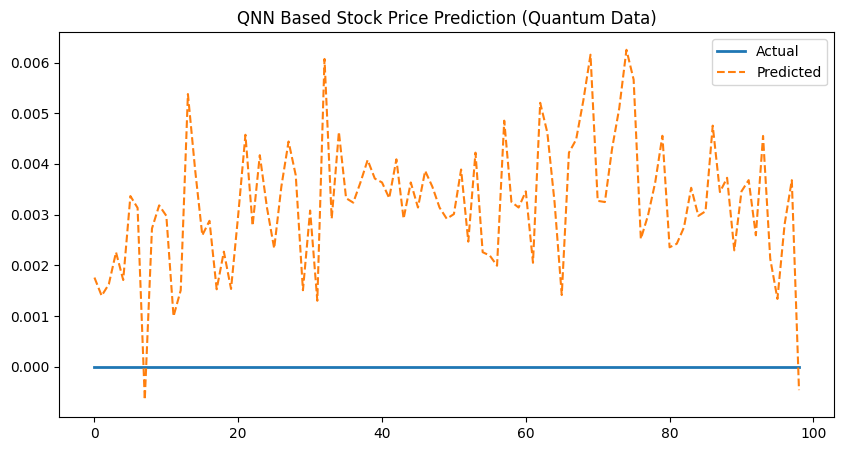

In [25]:
# Evaluating the results of quantum neural network

print('For Quantum Data: ')
y_predictions=evaluate(best_params,x_train)
r2 = round(float(r2_score(y_train, y_predictions)),3)
print('Predictions:' ,y_predictions[0:5])
print('Actuals: ',y_train[0:5])
print('Mean Squared Error: ',mean_squared_error(y_train,y_predictions))
print("R^2 Score:", r2)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(y_predictions[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Quantum Data)")
plt.show()

For Classical Data: 
Predictions: [1410.95766734 1410.96630781 1410.96081936 1410.94564503 1410.95882766]
Actuals:  [1377.2 1377.3 1377.6 1377.5 1377.9]
Mean Squared Error:  5456.539824690818
R^2 Score: -3.238


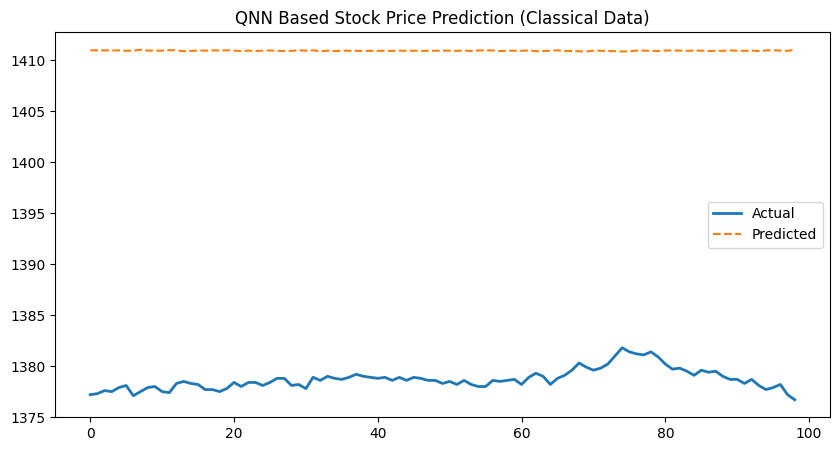

In [26]:
y_decoded=pnp.arccos(y_predictions)
y_pred= y.min() + (y_decoded / (2*pnp.pi)) * (y.max() - y.min())

print('For Classical Data: ')
print('Predictions:' ,y_pred[0:5])
print('Actuals: ',y[0:5])
print('Mean Squared Error: ',mean_squared_error(y,y_pred))
print("R^2 Score:", round(float(r2_score(y, y_pred)),3))

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y[0:99], label="Actual", linewidth=2)
plt.plot(y_pred[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Classical Data)")
plt.show()

# Trying something new

## Attempt 1

In [27]:
# Taking complete data and changing it
# Creating a quantum reservior
# Adding non-linearity by converting the data into higher dimensional data
# Using angle encoding to get the data as quantum state probability amplitudes

qubits=3

dev3=qml.device('default.qubit',wires=qubits)

@qml.qnode(device=dev3)
def quantum_reservoir(data_point,wires=qubits):
    exp_val_list=[]
    for i, value in enumerate(data_point):
        qml.Hadamard(wires=i)
        qml.RX(2*pnp.pi*value,wires=i)
        qml.RY(pnp.pi*value,wires=i)
        qml.RZ(3*pnp.pi*value,wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

def extract_features(data,qubits):
    features=[]

    for data_point in data:
        exp_val=quantum_reservoir(data_point=data_point,wires=qubits)
        features.append(exp_val)

    return features


In [28]:
quantum_data=data[['open','close','target']]
quantum_data=quantum_data.to_numpy()
quantum_data=extract_features(quantum_data,qubits=qubits)
quantum_data=pnp.array(quantum_data)

In [29]:
x_train=quantum_data[:,0:2]
y_train=quantum_data[:,2]
print('x_train:')
print(x_train[0:9])
print('\n')
print('y_train:')
print(y_train[0:9])
print('\n')

x_train:
[[-9.51056516e-01  3.09016994e-01]
 [ 3.09016994e-01  5.87785252e-01]
 [ 5.87785252e-01  8.09016994e-01]
 [ 1.00000000e+00  9.51056516e-01]
 [ 9.51056516e-01  1.00000000e+00]
 [ 1.00000000e+00  3.09016994e-01]
 [ 5.31130695e-13 -3.09016994e-01]
 [-3.09016994e-01  3.09016994e-01]
 [ 4.81836793e-14  1.00000000e+00]]


y_train:
[ 0.58778525  0.80901699  0.95105652  1.          0.30901699 -0.30901699
  0.30901699  1.          0.30901699]




In [30]:
# Running the quantum neural network

wires=2
layers=4
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=layers+1,n_wires=wires)
params=pnp.random.default_rng().random(size=params_shape)
best_params=optimization_jit(params, x_train, jnp.array(y_train), print_training=True)

Step: 0  Loss: 0.7145442366600037
Step: 50  Loss: 0.4410019516944885
Step: 100  Loss: 0.43855419754981995
Step: 150  Loss: 0.438092976808548
Step: 200  Loss: 0.43793487548828125
Step: 250  Loss: 0.437857449054718
Step: 300  Loss: 0.43778473138809204


Predictions: [1.6820431e-04 2.2655575e-01 3.0598328e-01 2.4275464e-01 2.5950849e-01]
Actuals:  [0.58778525 0.80901699 0.95105652 1.         0.30901699]
Mean Squared Error:  0.43778323644488526
R^2 Score: 0.081


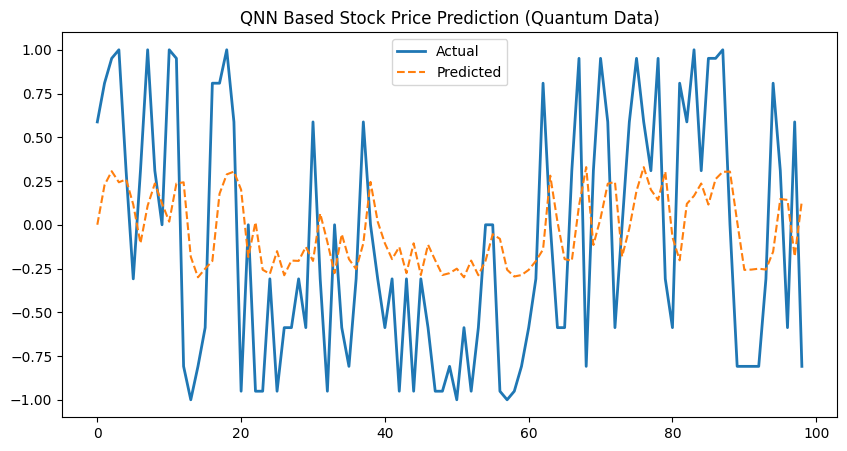

In [31]:
# Evaluating the results of quantum neural network

y_predictions=evaluate(best_params,x_train)
r2 = round(float(r2_score(y_train, y_predictions)),3)
print('Predictions:' ,y_predictions[0:5])
print('Actuals: ',y_train[0:5])
print('Mean Squared Error: ',mean_squared_error(y_train,y_predictions))
print("R^2 Score:", r2)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(y_predictions[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Quantum Data)")
plt.show()

For Classical Data: 
Predictions: [1410.99595126 1405.50036119 1403.51671925 1405.09934434 1404.68282195]
Actuals:  [1377.2 1377.3 1377.6 1377.5 1377.9]
Mean Squared Error:  5477.605007544401
R^2 Score: -3.255


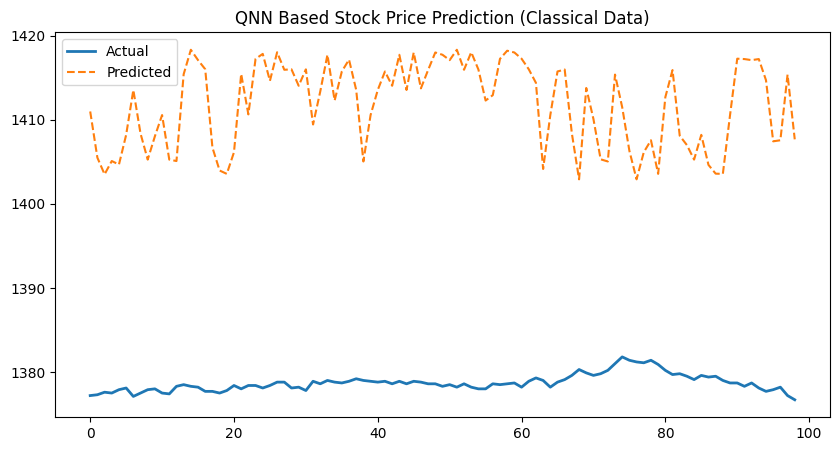

In [32]:
y_decoded=pnp.arccos(y_predictions)
y_pred= y.min() + (y_decoded / (2*pnp.pi)) * (y.max() - y.min())

print('For Classical Data: ')
print('Predictions:' ,y_pred[0:5])
print('Actuals: ',y[0:5])
print('Mean Squared Error: ',mean_squared_error(y,y_pred))
print("R^2 Score:", round(float(r2_score(y, y_pred)),3))

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y[0:99], label="Actual", linewidth=2)
plt.plot(y_pred[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Classical Data)")
plt.show()

## Attempt 2

In [33]:
qubits=3

dev3=qml.device('default.qubit',wires=qubits)

@qml.qnode(device=dev3)
def quantum_reservoir(data_point,wires=qubits):
  pnp.random.seed(42)
  theta_1=pnp.pi/6
  theta_2=pnp.pi/4
  reservoir_depth=5

  for i, value in enumerate(data_point):
      qml.Hadamard(wires=i)
      qml.RX(2*pnp.pi*value,wires=i)
      qml.RY(pnp.pi*value,wires=i)
      qml.RZ(3*pnp.pi*value,wires=i)

  for _ in range(reservoir_depth):

      for i in range(wires):
          qml.RY(pnp.random.uniform(0,pnp.pi),wires=i)

      for i in range(wires-1):
          qml.CNOT(wires=[i,i+1])

      for i in range(wires-2):
          qml.CRX(theta_1,wires=[i,i+1])
          qml.CRZ(theta_2,wires=[i+1,i+2])

  return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

def extract_features(data,qubits):
    features=[]

    for data_point in data:
        exp_val=quantum_reservoir(data_point=data_point,wires=qubits)
        features.append(exp_val)

    return features


In [34]:
quantum_data=data[['open','close','target']]
quantum_data=quantum_data.to_numpy()
quantum_data=extract_features(quantum_data,qubits=qubits)
quantum_data=pnp.array(quantum_data)

In [35]:
x_train=quantum_data[:,0:2]
y_train=quantum_data[:,2]
print('x_train:')
print(x_train[0:9])
print('\n')
print('y_train:')
print(y_train[0:9])
print('\n')

x_train:
[[-0.26056599 -0.34026318]
 [ 0.10838467 -0.5637458 ]
 [-0.72248034 -0.29854129]
 [-0.37461109 -0.40143806]
 [ 0.09728999 -0.44662167]
 [ 0.38934183  0.09815966]
 [ 0.50011407 -0.26972703]
 [ 0.1898325  -0.2766426 ]
 [-0.03259927  0.47035633]]


y_train:
[ 0.37304676  0.15282916 -0.55665169 -0.31064795 -0.5536302  -0.01904912
  0.43723943  0.02073996 -0.34808139]




In [36]:
# Running the quantum neural network

wires=2
layers=4
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=layers+1,n_wires=wires)
params=pnp.random.default_rng().random(size=params_shape)
best_params=optimization_jit(params, x_train, jnp.array(y_train), print_training=True)

Step: 0  Loss: 0.6589201092720032
Step: 50  Loss: 0.12279506027698517
Step: 100  Loss: 0.12027635425329208
Step: 150  Loss: 0.1178741604089737
Step: 200  Loss: 0.11738164722919464
Step: 250  Loss: 0.11723706126213074
Step: 300  Loss: 0.11710899323225021


Predictions: [-0.1096006  -0.11580461 -0.00011621 -0.10500097 -0.10498631]
Actuals:  [ 0.37304676  0.15282916 -0.55665169 -0.31064795 -0.5536302 ]
Mean Squared Error:  0.11710658583884871
R^2 Score: 0.07


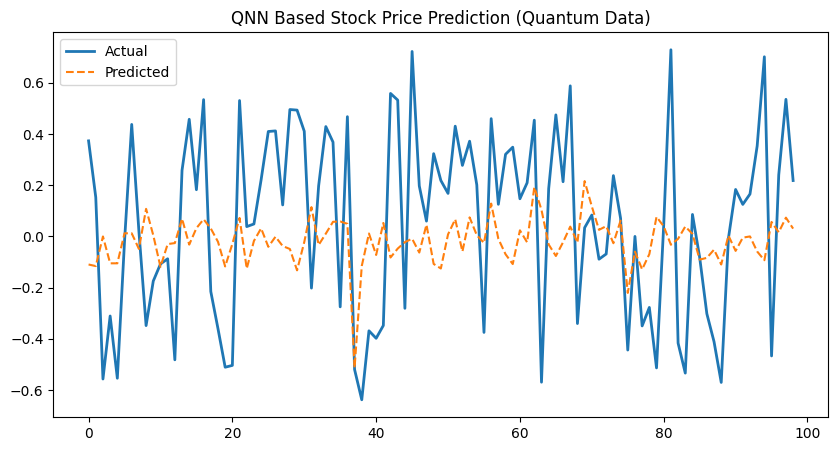

In [37]:
# Evaluating the results of quantum neural network

y_predictions=evaluate(best_params,x_train)
r2 = round(float(r2_score(y_train, y_predictions)),3)
print('Predictions:' ,y_predictions[0:5])
print('Actuals: ',y_train[0:5])
print('Mean Squared Error: ',mean_squared_error(y_train,y_predictions))
print("R^2 Score:", r2)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y_train[0:99], label="Actual", linewidth=2)
plt.plot(y_predictions[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Quantum Data)")
plt.show()

For Classical Data: 
Predictions: [1413.64276209 1413.79301386 1411.0027983  1413.5314296  1413.53107812]
Actuals:  [1377.2 1377.3 1377.6 1377.5 1377.9]
Mean Squared Error:  5443.391561018706
R^2 Score: -3.228


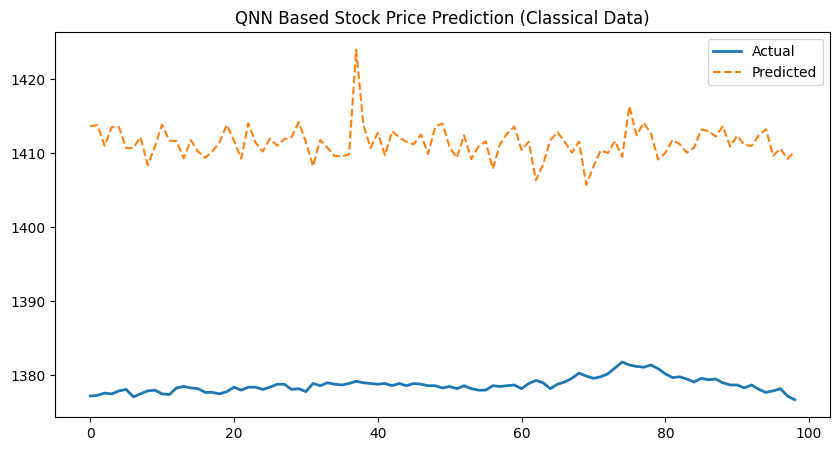

In [38]:
y_decoded=pnp.arccos(y_predictions)
y_pred= y.min() + (y_decoded / (2*pnp.pi)) * (y.max() - y.min())
print('For Classical Data: ')
print('Predictions:' ,y_pred[0:5])
print('Actuals: ',y[0:5])
print('Mean Squared Error: ',mean_squared_error(y,y_pred))
print("R^2 Score:", round(float(r2_score(y, y_pred)),3))

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y[0:99], label="Actual", linewidth=2)
plt.plot(y_pred[0:99], label="Predicted", linestyle="--")
plt.legend()
plt.title("QNN Based Stock Price Prediction (Classical Data)")
plt.show()